# **The Karplus-Strong Algorithm**

The Karplus-Strong algorithm is a simple digital feedback loop with an internal buffer of $M$ samples. The buffer is filled with a set of initial values and the loop, when running, produces an arbitraryly long output signal. Although elementary, the K-S loop can be used to synthesize interesting musical sounds as we will see in this notebook.

Let's start with a basic implementation of the K-S loop:

In [17]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [18]:
plt.rcParams['figure.figsize'] = (14,4)

In [19]:
def KS1(x, N):
  # Given a buffer of size x, gerenate an output of size N by copying identical copies of the buffer
  # Initiate the output with the buffer
  y = x

  # Iterate over to append copies of x
  while len(y) < N:
    y = np.append(y, x)

  y = y[0:N-1]

  return y

Then, since we're playing audio, we need to set the internal "clock" of the system, aka the sampling rate:

In [35]:
Fs = 16000 # Sampling rate

With this sampling rate, since the period of the generated signal is equal to the length of the inital buffer, we will be able to compute the fundamental frequency of the resulting sound. For instance, if we init the K-S algorithm with a vector of 50 values, the buffer will fit 16000/50=32016000/50=320 times in a second's worth of samples or, in other words, the resulting frequency will be 320Hz, which corresponds roughly to a E4 on a piano.

We still haven't talked about what to use as the initial values for the buffer. Well, the cool thing about K-S is that we can use pretty much anything we want; as a matter of fact, using random values will give you a totally fine sound. As a proof, consider this initial data set:


<StemContainer object of 3 artists>

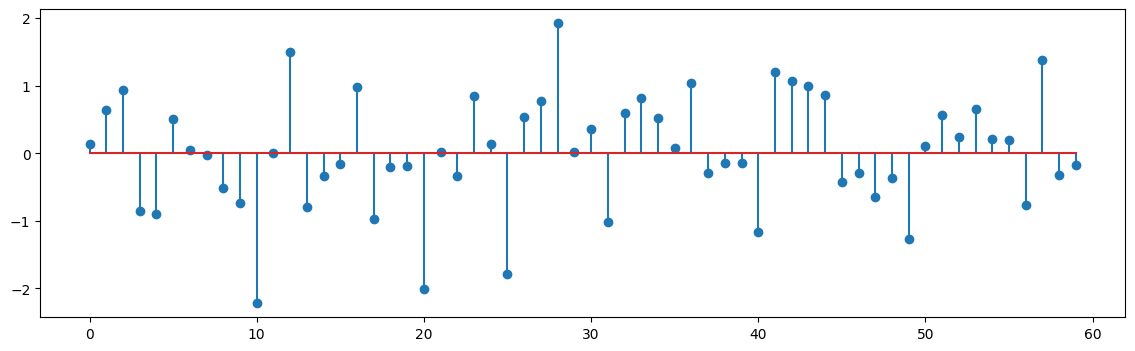

In [36]:
# Generate a random buffer with size 60
b = np.random.randn(60);
plt.stem(b)

Now generate a 2 second audio clip using the KS algorithm

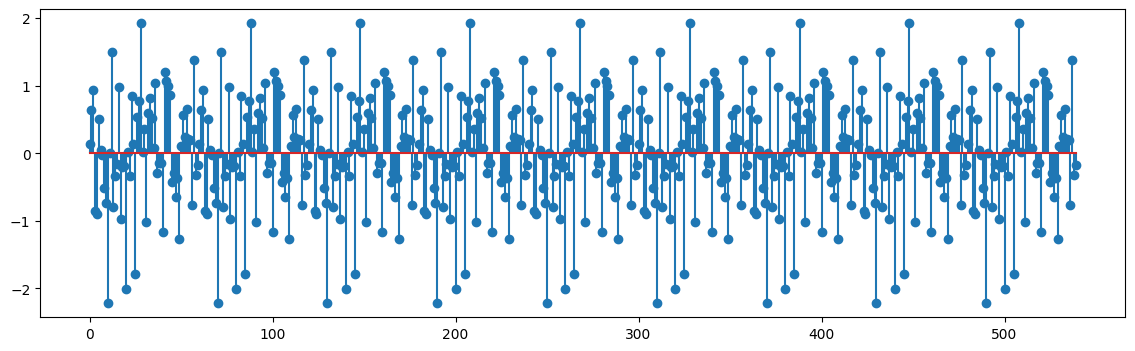

In [37]:
y = KS1(b, Fs * 2)
plt.stem(y[0:540]);

In [38]:
# Lets play this
IPython.display.Audio(y, rate=Fs)

In [39]:
# let's play an octave lower: just double the initial buffer's length
IPython.display.Audio(KS1(np.random.rand(100), Fs * 2), rate=Fs)

OK, so the K-S algorithm works! From the signal processing point of view, we can describe the system with the following block diagram (neglect the factor $\alpha$ for a moment)

The output can be expressed as
$$
    y[n] = x[n] + y[n - M]
$$
assuming that the input is the finite-support signal
$$
x[n] = \begin{cases}
    0 & \mbox{for $n < 0$} \\
    b_n & \mbox{for $0 \le n < M$} \\
    0 & \mbox{for $n \ge M$}
  \end{cases}
$$

Let's implement the K-S algorithm as a signal processing loop

In [40]:
def KS2(x, N):
  # Length of the input
  M = len(x)
  # Initialize output y
  y = np.zeros(N)
  for n in range(0, N):
    y[n] = (x[n] if n < M else 0) + (y[n-M] if n-M >= 0 else 0)
  return y

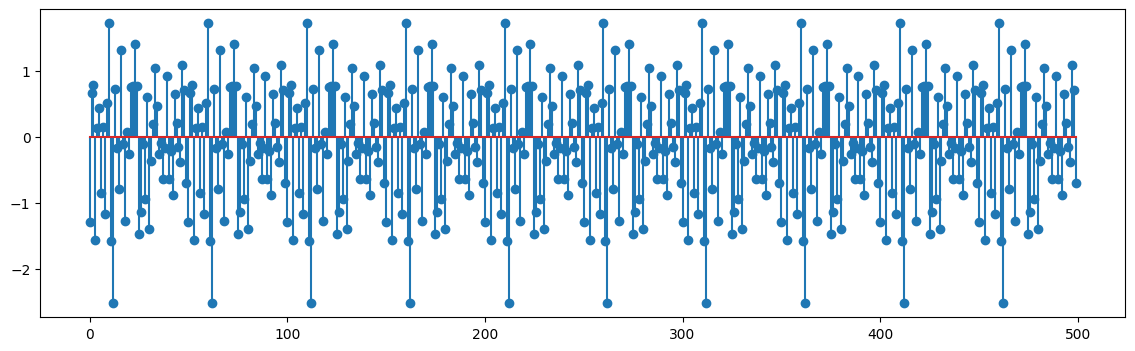

In [46]:
# Initialize the input signal
b = np.random.randn(50)
y = KS2(b, Fs*2)
plt.stem(y[0:500]);

In [52]:
IPython.display.Audio(y, rate=Fs)

By looking at block diagram we can see a simple modification that adds a lot of realism to the sound: by setting $\alpha$ to a value close to but less that one, we can introuce a decay in the note that produces guitar-like sounds:
$$
    y[n] = x[n] + \alpha y[n - M]
$$

In [48]:
def KS3(x, N, alpha = None):
  # Length of the input
  M = len(x)
  # Initialize output y
  y = np.zeros(N)
  for n in range(0, N):
    y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
  return y

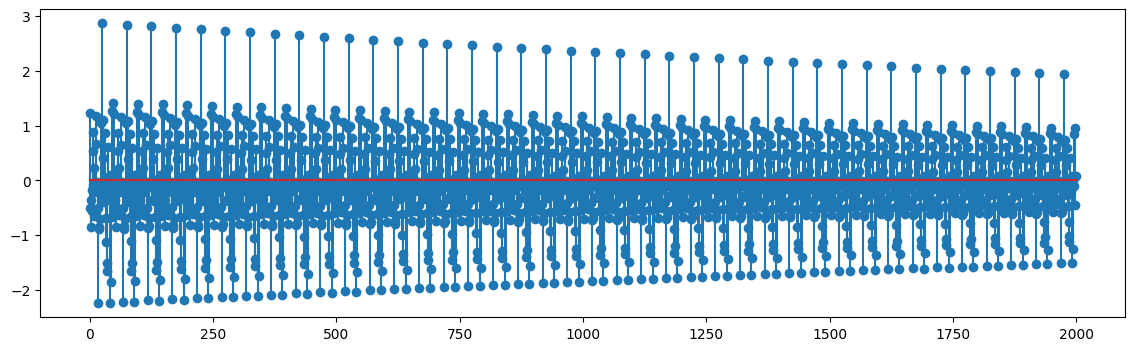

In [55]:
# Initialize the input signal
b = np.random.randn(50)
y = KS3(b, Fs*2, alpha=0.99)
plt.stem(y[0:2000]);

In [53]:
IPython.display.Audio(y, rate=Fs)

There is just one last detail (the devil's in the details, here as everywhere else). Consider the output of a dampened K-S loop; every time the initial buffer goes through the loop, it gets multiplied by $\alpha$ so that we can write
$$
  y[n] = \alpha^{\lfloor n/M \rfloor}x[n \mod M]
$$
(think about it and it will make sense). What that means is that the decay envelope is dependent on both $\alpha$ *and* $M$ or, in other words, the higher the pitch of the note, the faster its decay. For instance:

In [59]:
IPython.display.Audio(KS3(np.random.rand(50), Fs * 2, alpha=0.99), rate=Fs)

In [58]:
IPython.display.Audio(KS3(np.random.rand(10), Fs * 2, alpha=0.99), rate=Fs)

This is no good and therefore we need to compensate so that, if $\alpha$ is the same, the decay rate is the same. This leads us to the last implementation of the K-S algorithm:

In [60]:
def KS4(x, N, alpha = None):
  # Length of the input
  M = len(x)
  ref_len = 50
  # Scale the alpha based on M
  alpha = alpha ** (float(M)/ref_len)
  # Initialize output y
  y = np.zeros(N)
  for n in range(0, N):
    y[n] = (x[n] if n < M else 0) + alpha * (y[n-M] if n-M >= 0 else 0)
  return y

In [63]:
IPython.display.Audio(KS4(np.random.rand(50), Fs * 2, alpha=0.99), rate=Fs)

In [64]:
IPython.display.Audio(KS4(np.random.rand(10), Fs * 2, alpha=0.99), rate=Fs)